In [58]:
import numpy as np
import pandas as pd
from math import floor, ceil
from numpy.linalg import cholesky, inv, solve 
from scipy.linalg import cho_solve
from scipy.stats import wishart, invwishart, gamma
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


In [2]:
def load_dataset(datafile, parse_dates=None):
    df = pd.read_csv(datafile, delimiter=',', parse_dates=parse_dates)
    return df


In [3]:
g_datafolder = '/development/data'
g_customer_dataset = '{}/olist_customers_dataset.csv'.format(g_datafolder)
g_orders_dataset = '{}/olist_orders_dataset.csv'.format(g_datafolder)
g_payments_dataset = '{}/olist_order_payments_dataset.csv'.format(g_datafolder)
g_orderitems_dataset = '{}/olist_order_items_dataset.csv'.format(g_datafolder)


In [4]:
customer_df = load_dataset(g_customer_dataset)
parse_dates = ['order_purchase_timestamp', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
orders_df = load_dataset(g_orders_dataset, parse_dates=parse_dates)
payments_df = load_dataset(g_payments_dataset)
orderitems_df = load_dataset(g_orderitems_dataset)
cust_ord_df = orders_df.set_index('customer_id').join(customer_df.set_index('customer_id'), how="inner").reset_index()
cust_ord_df = cust_ord_df.set_index('order_id').join(orderitems_df.set_index('order_id'), how="inner").reset_index()
cust_ord_df['monetary_value'] = np.round(cust_ord_df['price'] + cust_ord_df['freight_value'], 0)
cust_ord_df['order_date'] = cust_ord_df.order_purchase_timestamp.dt.date
cust_ord_df['cancelled'] = 0.0
cust_ord_df['cancelled'][cust_ord_df.order_status == 'canceled'] = 1.0
customer_id_col='customer_unique_id'
datetime_col='order_date'
monetary_value_col='monetary_value' 
calibration_period_end = datetime(2018,4,1).date()
observation_period_end = cust_ord_df.order_purchase_timestamp.max().date()


In [5]:

def add_datediffcolumn(df, col_dt1, col_dt2, colname):
    df[colname] = np.round((df[col_dt1] - df[col_dt2]).dt.days, 0) * 1.0
    #df[colname] = np.round((df[col_dt1] - df[col_dt2]) / np.timedelta64(1, 'M'), 0)
    df[colname][df[colname].isna()] = 0.0
    return df

def get_calibration_holdout_data(df
                               , customer_id_col='id'
                               , datetime_col='date'
                               , calibration_period_end=None
                               , observation_period_end=None
                               , monetary_value_col='value'
                               , covariates=None):
    allcols = [customer_id_col, datetime_col, monetary_value_col]
    if covariates is not None:
        allcols = allcols + covariates
    df = df[allcols]
    df['obs'] = 0
    df['obs'][df[datetime_col] >= calibration_period_end] = 1
    df['x'] = 1.0
    sort_cols = [customer_id_col, 'obs', datetime_col]
    agg_map = {'x':'count', monetary_value_col:'mean'}
    if covariates is not None:
        for covariate in covariates:
            agg_map[covariate] = 'sum'
    df = df.groupby([customer_id_col, 'obs', datetime_col]).agg(agg_map).reset_index() #.sort_values(sort_cols).groupby([customer_id_col, 'obs']).cumcount()+1
    df['x'] = df.sort_values(sort_cols).groupby([customer_id_col, 'obs']).cumcount()+1    
    df['x'] = df['x'] - 1.0
    df['x'][df.obs == 1] += 1.0 
    df['first'] = df[datetime_col]       
    df['last'] = df[datetime_col]       
    groupby_cols = [customer_id_col, 'obs']
    all_cols = groupby_cols + [datetime_col, monetary_value_col, 'x', 'first', 'last'] + covariates
    agg_map = {monetary_value_col:'mean', 'x':'max', 'first':'min', 'last':'max' }
    if covariates is not None:
        for covariate in covariates:
            agg_map[covariate] = 'sum'
    df = df.sort_values(sort_cols)[all_cols].groupby(groupby_cols).agg(agg_map).reset_index()
    df['endobs'] = calibration_period_end    
    df['endobs'][df.obs == 1] = observation_period_end
    df = add_datediffcolumn(df, 'last', 'first', 't')
    df = add_datediffcolumn(df, 'endobs', 'first', 'T')
    df['T'][df.obs == 1] = np.round((observation_period_end - calibration_period_end).days, 0) * 1.0
    cols = ['x', 't', 'T', monetary_value_col] + covariates
    cal_df = df[df.obs == 0][[customer_id_col] + cols] 
    cal_df.columns = [customer_id_col] + ['{}_cal'.format(colname) for colname in cols]
    hold_df = df[df.obs == 1][[customer_id_col] + cols] 
    hold_df.columns = [customer_id_col] + ['{}_holdout'.format(colname) for colname in cols]
    df = cal_df.set_index(customer_id_col).join(hold_df.set_index(customer_id_col), how="left").reset_index().fillna(0.0)
    return df


In [6]:
df = get_calibration_holdout_data(cust_ord_df
                                , customer_id_col=customer_id_col
                                , datetime_col=datetime_col
                                , calibration_period_end=calibration_period_end
                                , observation_period_end=observation_period_end
                                , monetary_value_col='monetary_value'
                                , covariates=['cancelled'])

## Implementation

In [ ]:
# x ==> number of repeat purchases
# t ==> First purchase to last purchase
# T ==> First purchase to end of observation period


In [181]:
# Setup Regressors (Covariates) for location of 1st-stage prior, i.e. beta = [log(lambda), log(mu)]
def set_regressors(data, covariates=[]):
    data['intercept'] = 1.0
    covariates = ['intercept'] + covariates
    covars = np.matrix(data[covariates])
    K = len(covariates)
    return covariates, covars, K

def get_diag(shape, val):
    d = np.zeros(shape=shape)
    np.fill_diagonal(d, val) 
    return d

def get_map_from_array(x):
    a_map = {}
    count = 0
    for val in x:
        a_map[val] = count
        count += 1
    return a_map

# set hyper priors "log_lambda", "log_mu"
def set_hyperpriors(K):  
    beta_0 = np.zeros(shape=(K, 2))
    A_0 = get_diag(shape=(K, K), val=0.01) # diffuse precision matrix
    # set diffuse hyper-parameters for 2nd-stage prior of gamma_0; follows defaults from rmultireg example
    nu_00 = 3 + K  # 30
    gamma_00 = get_diag(shape=(2, 2), val=nu_00) # diffuse precision matrix
    hyper_prior = {'beta_0': beta_0, 'A_0':A_0, 'nu_00':nu_00, 'gamma_00':gamma_00}
    return hyper_prior

def draw_z(data, level_1, level_1_params_map):
    tx = data['t_cal']
    Tcal = data['T_cal']
    p_lambda = level_1[level_1_params_map['lambda'], ]
    p_mu = level_1[level_1_params_map['mu'], ]
    mu_lam = p_mu + p_lambda
    t_diff = Tcal - tx
    prob = 1 / (1 + (p_mu / mu_lam) * (np.exp(mu_lam * t_diff) - 1))
    z = (np.random.uniform(size=len(prob)) < prob)
    z[z == True] = 1
    z = z.astype(int)
    return list(z.values)

def draw_tau(data, level_1, level_1_params_map):
    N = len(data)
    tx = data['t_cal']
    Tcal = data['T_cal']
    p_lambda = level_1[level_1_params_map['lambda'], ]
    p_mu = level_1[level_1_params_map['mu'], ]

    mu_lam = p_mu + p_lambda
    z = level_1[level_1_params_map['z'], ]

    alive = (z == 1)
    tau = np.zeros(shape=(N))

    # Case: still alive - left truncated exponential distribution -> [T.cal, Inf]
    if (np.sum(alive) > 0):
        tau[alive] = Tcal[alive] + np.random.exponential(scale=1.0/p_mu[alive], size=np.sum(alive))

    # Case: churned - double truncated exponential distribution -> [tx, T.cal]
    if (np.sum(~alive) > 0):
        mu_lam_tx = np.minimum(700, mu_lam[~alive] * tx[~alive])
        mu_lam_Tcal = np.minimum(700, mu_lam[~alive] * Tcal[~alive])
        rand = np.random.uniform(size=np.sum(~alive))        
        tau[~alive] = (-1.0 * np.log((1.0 - rand) * np.exp(-1.0 * mu_lam_tx) + rand * np.exp((-1.0 * mu_lam_Tcal)))) / mu_lam[~alive]

    return tau

def chol2inv(chol):
    return cho_solve((chol, False), np.eye(chol.shape[0])) 

def draw_wishart(df, scale):
    W = wishart.rvs(df, scale)
    IW = inv(W)
    C = cholesky(W).T
    CI = inv(C)
    return W, IW, C, CI

def rmultireg(Y, X, Bbar, A, nu, V):
    # standard multi-variate normal regression update
    # Slide 33 in http://ice.uchicago.edu/2008_presentations/Rossi/ICE_tutorial_2008.pdf
    n = Y.shape[0]
    m = Y.shape[1]
    k = X.shape[1]    

    RA = cholesky(A)
    W = np.concatenate((X, RA), axis=0) 
    Z = np.concatenate((Y, RA*Bbar), axis=0)
    IR = solve(np.triu(cholesky(np.dot(W.T, W)).T), np.eye(k,k)) #trimatu interprets the matrix as upper triangular and makes solve more efficient
    Btilde = np.dot(np.dot(IR, IR.T), np.dot(W.T,Z))
    E = Z - np.dot(W, Btilde)
    S = np.dot(E.T, E)
    W, IW, C, CI = draw_wishart(df=nu+n, scale=chol2inv(cholesky(V+S).T))
    samples = np.random.normal(size=k*m).reshape(k,m)
    B = Btilde + np.dot(IR, np.dot(samples, CI.T))
    return {'beta': B.T, 'gamma':IW}

def draw_level_2(covars, level_1, level_1_params_map, hyper_prior):
    # standard multi-variate normal regression update
    Y = np.log(level_1[[level_1_params_map['lambda'], level_1_params_map['mu']],].T)
    X = covars
    Bbar = hyper_prior['beta_0']
    A = hyper_prior['A_0']
    nu = hyper_prior['nu_00']
    V = hyper_prior['gamma_00']
    
    return rmultireg(Y, X, Bbar, A, nu, V)

def log_post(log_theta, mvmean, x, z, Tcal, tau, inv_gamma):
    log_lambda = log_theta[0,:] 
    log_mu = log_theta[1,:]
    diff_theta = np.subtract(log_theta, mvmean.T)
    diff_lambda = diff_theta[0,:]
    diff_mu = diff_theta[1,:]
    likel = (x * log_lambda) + ((1 - z) * log_mu) - (((z * Tcal) + (1 - z) * tau) * (np.exp(log_lambda) + np.exp(log_mu)))
    prior = -0.5 * ((np.square(diff_lambda) * inv_gamma[0, 0]) + (2 * np.multiply(diff_lambda, diff_mu) * inv_gamma[0, 1]) + (np.square(diff_mu) * inv_gamma[1, 1]))
    post = np.add(likel[0], prior)    
    post[0,log_mu > 5] = np.NINF  # cap !!
    return post

def step(cur_log_theta, cur_post, gamma, N, mvmean, x, z, Tcal, tau, inv_gamma):
    new_log_theta = cur_log_theta + np.vstack((gamma[0, 0] * np.random.standard_t(df=3, size=N), gamma[1, 1] * np.random.standard_t(df=3, size=N)))
    new_log_theta[0,:] = np.maximum(np.minimum(new_log_theta[0,:], 70), -70)
    new_log_theta[1,:] = np.maximum(np.minimum(new_log_theta[1,:], 70), -70)
    new_post = log_post(new_log_theta, mvmean, x, z, Tcal, tau, inv_gamma)
    # accept/reject new proposal
    mhratio = np.exp(new_post - cur_post)
    unif = np.random.uniform(size=N)
    accepted = np.asarray(mhratio > unif)[0]
    cur_log_theta[:,accepted] = new_log_theta[:, accepted]
    cur_post[0,accepted] = new_post[0,accepted]
    return {'cur_log_theta':cur_log_theta, 'cur_post':cur_post}

def draw_level_1(data, covars, level_1, level_1_params_map, level_2):
    # sample (lambda, mu) given (z, tau, beta, gamma)
    N = len(data)
    x = data['x_cal']
    Tcal = data['T_cal']
    z = level_1[level_1_params_map['z'], ]
    tau = level_1[level_1_params_map['tau'], ]
    mvmean = np.dot(covars, level_2['beta'].T)
    gamma = level_2['gamma']
    inv_gamma = inv(gamma)
    
    cur_lambda = level_1[level_1_params_map['lambda'], ]
    cur_mu = level_1[level_1_params_map['mu'], ]

    # current state
    cur_log_theta = np.vstack((np.log(cur_lambda), np.log(cur_mu)))
    cur_post = log_post(cur_log_theta, mvmean, x, z, Tcal, tau, inv_gamma)
    
    iter = 1  # how high do we need to set this? 1/5/10/100?
    for i in range(0, iter):
        draw = step(cur_log_theta, cur_post, gamma, N, mvmean, x, z, Tcal, tau, inv_gamma)
        cur_log_theta = draw['cur_log_theta']
        cur_post = draw['cur_post']

    cur_theta = np.exp(cur_log_theta)

    return {'lambda':cur_theta[0,:], 'mu':cur_theta[1,:]}

def run_single_chain(data, covariates, K, hyper_prior, nsample, nburnin, nskip):
    ## initialize arrays for storing draws ##
    LOG_LAMBDA = 0
    LOG_MU = 1
    nr_of_cust = len(data)
    #nr_of_draws = nburnin + nsample * nskip
    nr_of_draws = nburnin + nsample

    # The 4 is for "lambda", "mu", "tau", "z"
    level_1_params_map = get_map_from_array(['lambda', 'mu', 'tau', 'z'])
    level_1_draws = np.zeros(shape=(nsample, 4, nr_of_cust))

    level_2_draws = np.zeros(shape=(nsample, (2*K)+3))
    nm = ['log_lambda', 'log_mu']
    if (K > 1):
        nm = ['{}_{}'.format(val2, val1) for val1 in covariates for val2 in nm]
    nm.extend(['var_log_lambda', 'cov_log_lambda_log_mu', 'var_log_mu'])
    level_2_params_map = get_map_from_array(nm)
        
    ## initialize parameters ##
    data['t_cal_tmp'] = data['t_cal']
    data['t_cal_tmp'][data.t_cal == 0] = data['T_cal'][data.t_cal == 0] 
    level_1 = level_1_draws[1,]
    x_cal_mean = np.mean(data['x_cal'])
    t_cal_tmp_mean = np.mean(data['t_cal_tmp'])
    level_1[level_1_params_map['lambda'], ] = x_cal_mean/t_cal_tmp_mean
    level_1[level_1_params_map['mu'], ] = 1 / (data['t_cal'] + 0.5 / level_1[level_1_params_map['lambda'], ])
    
    ## run MCMC chain ##
    hyper_prior['beta_0'][0, LOG_LAMBDA] = np.log(np.mean(level_1[level_1_params_map['lambda'], ]))
    hyper_prior['beta_0'][0, LOG_MU] = np.log(np.mean(level_1[level_1_params_map['mu'], ]))
    
    for i in range(0, nr_of_draws):
        # draw individual-level parameters
        level_1[level_1_params_map['z'], ] = draw_z(data, level_1, level_1_params_map)
        level_1[level_1_params_map['tau'], ] = draw_tau(data, level_1, level_1_params_map)

        level_2 = draw_level_2(covars, level_1, level_1_params_map, hyper_prior)
        draw = draw_level_1(data, covars, level_1, level_1_params_map, level_2)
        level_1[level_1_params_map['lambda'], ] = draw["lambda"]
        level_1[level_1_params_map['mu'], ] = draw["mu"]
        
        #nk = int(round((i - nburnin) / nskip))        
        if (i >= nburnin):
            #Store
            idx = i - nburnin
            level_1_draws[idx,:,:] = level_1 # nolint
            level_2_draws[idx,:] = list(np.array(level_2['beta'].T).reshape(-1)) + [level_2['gamma'][0, 0], level_2['gamma'][0, 1], level_2['gamma'][1,1]]
        if (i % 100) == 0:
            print('draw: {}'.format(i))
            
    return {"level_1":level_1_draws, "level_1_params_map":level_1_params_map, "level_2":level_2_draws, "level_2_params_map":level_2_params_map}    

####MCMC Functions
def get_correlation(draws):
    l2pmap = draws["level_2_params_map"]
    draw_means = np.mean(draws['level_2'], axis=0)
    corr = draw_means[l2pmap['cov_log_lambda_log_mu']]/(np.sqrt(draw_means[l2pmap['var_log_lambda']]) * np.sqrt(draw_means[l2pmap['var_log_mu']]))
    return corr

def get_nr_of_cust(draws):
    nr_of_cust = draws["level_1"].shape[2]
    return nr_of_cust

def PAlive(draws):
    l1pmap = draws["level_1_params_map"]
    nr_of_cust = get_nr_of_cust(draws)
    p_alive = np.mean(draws["level_1"][:,l1pmap['z'],:], axis=1)
    return p_alive

def draw_left_truncated_gamma(lower, k, lamda):
    pg = gamma.cdf(x=lower, a=k, scale=1.0/(k*lamda))
    rand = np.random.uniform(1, pg, 1)
    qg = gamma.ppf(q=rand, a=k, scale=1.0/(k*lamda))
    return qg

def DrawFutureTransactions(data, draws, sample_size=None):
    nr_of_draws = draws["level_2"].shape[0]
    if sample_size is not None:
            nr_of_draws = sample_size
    nr_of_cust = get_nr_of_cust(draws)
    parameters = draws["level_1_params_map"]
    x_holdout = np.zeros(shape=(nr_of_draws, nr_of_cust))
    t_cal = data['t_cal']
    T_holdout = data['T_holdout']
    T_cal = data['T_cal']

    for i in range(0, nr_of_cust):
        print('...processing customer: {} of {}'.format(i, nr_of_cust))
        Tcal = T_cal[i]
        Tholdout = T_holdout[i]
        tcal = t_cal[i]
        taus = draws['level_1'][:,parameters['tau'],i]
        ks = np.ones(shape=(len(taus)))    
        lamdas = draws['level_1'][:,parameters['lambda'],i]
        if sample_size is not None:
            taus = taus[sample_size]
            ks = ks[sample_size]
            lambdas = lambdas[sample_size]

        alive = taus > Tcal
        # Case: customer alive
        idx = 0
        for alive_val in alive:
            if alive_val:
                # sample itt which is larger than (Tcal-tx)
                itts = draw_left_truncated_gamma(Tcal - tcal, ks[idx], lamdas[idx])
                # sample 'sufficiently' large amount of inter-transaction times
                minT = np.minimum(Tcal + Tholdout - tcal, taus[idx] - tcal)
                nr_of_itt_draws = int(np.maximum(10, np.round(minT * lamdas[idx])))
                itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*2))))
                if (np.sum(itts) < minT):
                    itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*4))))
                if (np.sum(itts) < minT):
                    itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*800))))
                if (np.sum(itts) < minT):
                    print("...not enough inter-transaction times sampled! cust: {}, draw: {}, {} < {}".format(i, idx, np.sum(itts), minT))
                x_holdout[idx, i] = np.sum(np.cumsum(itts) < minT)
            idx += 1
        if (np.any(~alive)):
            x_holdout[~alive, i] = 0
    return x_holdout



In [41]:
def PActive(x_holdout):
    return(apply(xstar, 2, function(x) mean(x > 0)))


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  33., 266.]),
 array([0.        , 0.08833263, 0.17666525, 0.26499788, 0.3533305 ,
        0.44166313, 0.52999576, 0.61832838, 0.70666101, 0.79499364,
        0.88332626]),
 <a list of 10 Patch objects>)

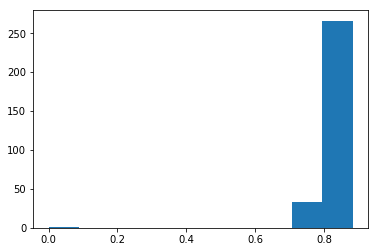

In [43]:
plt.hist(p_alive)

In [36]:
l1pmap

{'lambda': 0, 'mu': 1, 'tau': 2, 'z': 3}

In [27]:
get_correlation(draws)

-0.006463037191956953

In [141]:
parse_dates = ['first']
g_cbs_dataset = '{}/cbs.csv'.format(g_datafolder)
df = load_dataset(g_cbs_dataset, parse_dates=parse_dates)
covariates, covars, K = set_regressors(df, covariates=["first_sales"])
hyper_prior = set_hyperpriors(K)
draws = run_single_chain(df, covariates=covariates, K=K, hyper_prior=hyper_prior, nsample=300, nburnin=700, nskip=10)

# Main routine
#covariates, covars, K = set_regressors(df, covariates=["cancelled_cal"])
#hyper_prior = set_hyperpriors(K)
#draws = run_single_chain(df, covariates=covariates, K=K, hyper_prior=hyper_prior, nsample=30, nburnin=70, nskip=10)


draw: 0
draw: 100


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 200


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 300


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 400


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 500


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp


draw: 600
draw: 700
draw: 800
draw: 900


In [142]:
draws["level_2_params_map"]

{'log_lambda_intercept': 0,
 'log_mu_intercept': 1,
 'log_lambda_first_sales': 2,
 'log_mu_first_sales': 3,
 'var_log_lambda': 4,
 'cov_log_lambda_log_mu': 5,
 'var_log_mu': 6}

In [143]:
df.head()

,cust,x_cal,t_cal,litt,sales,sales_cal,first,T_cal,T_holdout,x_holdout,sales_holdout,first_sales,intercept,t_cal_tmp
0,4,2,30.428571,4.219508,74.02,44.69,1997-01-01,38.857143,39,1,26.48,0.02933,1.0,30.428571
1,18,0,0.000000,0.000000,14.96,0.00,1997-01-04,38.428571,39,0,0.00,0.01496,1.0,38.428571
2,21,1,1.714286,0.538997,75.11,11.77,1997-01-01,38.857143,39,0,0.00,0.06334,1.0,1.714286
3,50,0,0.000000,0.000000,6.79,0.00,1997-01-01,38.857143,39,0,0.00,0.00679,1.0,38.857143
4,60,0,0.000000,0.000000,21.75,0.00,1997-02-01,34.428571,39,0,0.00,0.02175,1.0,34.428571


In [177]:
sample_size = None
data = df

def DrawFutureTransactions(data, draws, sample_size=None):
    nr_of_draws = draws["level_2"].shape[0]
    if sample_size is not None:
            nr_of_draws = sample_size
    nr_of_cust = get_nr_of_cust(draws)
    parameters = draws["level_1_params_map"]
    x_holdout = np.zeros(shape=(nr_of_draws, nr_of_cust))
    t_cal = data['t_cal']
    T_holdout = data['T_holdout']
    T_cal = data['T_cal']

    for i in range(0, nr_of_cust):
        print('...processing customer: {} of {}'.format(i, nr_of_cust))
        Tcal = T_cal[i]
        Tholdout = T_holdout[i]
        tcal = t_cal[i]
        taus = draws['level_1'][:,parameters['tau'],i]
        ks = np.ones(shape=(len(taus)))    
        lamdas = draws['level_1'][:,parameters['lambda'],i]
        if sample_size is not None:
            taus = taus[sample_size]
            ks = ks[sample_size]
            lambdas = lambdas[sample_size]

        alive = taus > Tcal
        # Case: customer alive
        idx = 0
        for alive_val in alive:
            if alive_val:
                # sample itt which is larger than (Tcal-tx)
                itts = draw_left_truncated_gamma(Tcal - tcal, ks[idx], lamdas[idx])
                # sample 'sufficiently' large amount of inter-transaction times
                minT = np.minimum(Tcal + Tholdout - tcal, taus[idx] - tcal)
                nr_of_itt_draws = int(np.maximum(10, np.round(minT * lamdas[idx])))
                itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*2))))
                if (np.sum(itts) < minT):
                    itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*4))))
                if (np.sum(itts) < minT):
                    itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*800))))
                if (np.sum(itts) < minT):
                    print("...not enough inter-transaction times sampled! cust: {}, draw: {}, {} < {}".format(i, idx, np.sum(itts), minT))
                x_holdout[idx, i] = np.sum(np.cumsum(itts) < minT)
            idx += 1
        if (np.any(~alive)):
            x_holdout[~alive, i] = 0
    return x_holdout
    

...processing customer: 0 of 1


In [180]:
x_holdout[:,0]

array([40.,  0., 17.,  9., 24., 31., 32., 36., 34., 11., 37., 25.,  0.,
        5., 33.,  1., 26.,  0.,  0.,  0., 19., 28., 28., 17.,  0.,  6.,
       25.,  5., 33.,  0., 34.,  0.,  0., 28., 29.,  0., 33., 35.,  1.,
        0.,  3., 27.,  0., 36., 27., 34.,  7., 35., 48., 31., 33., 29.,
       12., 17.,  7., 14., 35.,  0., 34.,  4., 32., 19., 38., 19.,  2.,
        0., 23.,  0., 44., 19., 36., 25., 25., 30., 30.,  0., 38., 34.,
       17., 32.,  0., 31.,  0., 29., 19.,  4., 26.,  0., 40., 28., 24.,
       15., 34.,  0., 31., 25.,  0., 34., 25., 31., 15.,  5., 21., 42.,
       34.,  0.,  0., 20.,  0., 27., 35.,  8., 25.,  0., 18., 22.,  0.,
       11.,  0., 35.,  0., 25.,  0., 37.,  0.,  0., 25., 14., 23., 27.,
        0.,  0.,  0.,  6.,  0.,  0., 24., 16.,  0.,  0.,  0., 43., 20.,
        6., 28., 39., 14.,  0.,  0.,  0., 20., 28., 31., 16.,  0., 18.,
       31., 49.,  0.,  2., 14.,  2.,  0.,  0.,  3., 17.,  0.,  0.,  0.,
        0., 22., 25., 29., 34., 29.,  0.,  6., 44.,  6., 28., 23

In [156]:
nr_of_itt_draws

10.0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
mcmc.DrawFutureTransactions <- function(cal.cbs, draws, T.star = cal.cbs$T.star, sample_size = NULL) {

  if (is.null(sample_size)) {
    nr_of_draws <- niter(draws$level_2) * nchain(draws$level_2)
  } else {
    stopifnot(is.numeric(sample_size))
    nr_of_draws <- as.integer(sample_size)
  }
  stopifnot(nr_of_draws >= 1)
  nr_of_cust <- length(draws$level_1)
  parameters <- varnames(draws$level_1[[1]])

  if (nr_of_cust != nrow(cal.cbs))
    stop("mismatch between number of customers in parameters 'cal.cbs' and 'draws'")
  if (is.null(T.star))
    stop("T.star is missing")

  x.stars <- array(NA_real_, dim = c(nr_of_draws, nr_of_cust))
  if (length(T.star) == 1)
    T.star <- rep(T.star, nr_of_cust)

  draw_left_truncated_gamma <- function(lower, k, lambda) {
    rand <- runif(1, pgamma(lower, k, k * lambda), 1)
    qgamma(rand, k, k * lambda)
  }

  for (cust in 1:nrow(cal.cbs)) {
    Tcal <- cal.cbs$T.cal[cust]
    Tstar <- T.star[cust]
    tx <- cal.cbs$t.x[cust]
    taus <- drop(as.matrix(draws$level_1[[cust]][, "tau"]))
    if ("k" %in% parameters) {
      ks <- drop(as.matrix(draws$level_1[[cust]][, "k"]))
    } else {
      ks <- rep(1, length(taus))
    }
    lambdas <- drop(as.matrix(draws$level_1[[cust]][, "lambda"]))
    stopifnot(length(taus) == length(ks) && length(taus) == length(lambdas))
    if (!is.null(sample_size)) {
      idx <- sample(length(taus), size = sample_size, replace = TRUE)
      taus <- taus[idx]
      ks <- ks[idx]
      lambdas <- lambdas[idx]
    }
    alive <- (taus > Tcal)

    # Case: customer alive
    for (draw in which(alive)) {
      # sample itt which is larger than (Tcal-tx)
      itts <- draw_left_truncated_gamma(Tcal - tx, ks[draw], lambdas[draw])
      # sample 'sufficiently' large amount of inter-transaction times
      minT <- pmin(Tcal + Tstar - tx, taus[draw] - tx)
      nr_of_itt_draws <- pmax(10, round(minT * lambdas[draw]))
      itts <- c(itts, rgamma(nr_of_itt_draws * 2, shape = ks[draw], rate = ks[draw] * lambdas[draw]))
      if (sum(itts) < minT)
        itts <- c(itts, rgamma(nr_of_itt_draws * 4, shape = ks[draw], rate = ks[draw] * lambdas[draw]))
      if (sum(itts) < minT)
        itts <- c(itts, rgamma(nr_of_itt_draws * 800, shape = ks[draw], rate = ks[draw] * lambdas[draw]))
      if (sum(itts) < minT)
        stop("not enough inter-transaction times sampled! cust:", cust, " draw:", draw, " ", sum(itts),
          " < ", minT)
      x.stars[draw, cust] <- sum(cumsum(itts) < minT)
    }

    # Case: customer churned
    if (any(!alive)) {
      x.stars[!alive, cust] <- 0
    }
  }
  return(x.stars)
}


#' Calculates P(active) based on drawn future transactions.
#'
#' @param xstar Future transaction draws as returned by
#'   \code{\link{mcmc.DrawFutureTransactions}}.
#' @return numeric A vector with the customers' probabilities of being active
#'   during the holdout period.
#' @export
#' @examples
#' data("groceryElog")
#' cbs <- elog2cbs(groceryElog, T.cal = "2006-12-31")
#' param.draws <- pnbd.mcmc.DrawParameters(cbs,
#'   mcmc = 200, burnin = 100, thin = 20, chains = 1) # short MCMC to run demo fast
#' xstar.draws <- mcmc.DrawFutureTransactions(cbs, param.draws)
#' cbs$pactive <- mcmc.PActive(xstar.draws)
#' head(cbs)
mcmc.PActive <- function(xstar) {
  return(apply(xstar, 2, function(x) mean(x > 0)))
}
